In [16]:
import warnings
warnings.filterwarnings('ignore')
import astropy
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.signal import convolve
from astropy.convolution import convolve

#import mirisim components
import numpy  as np
from mirisim import skysim, obssim
#import the scene configuration parser
from mirisim.config_parser import SceneConfig

#import astropy components
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astropy import units as u

#import MEDIS components
from inspect import getframeinfo, stack
import proper

from medis.params import sp, ap, tp
from medis.utils import dprint
import medis.optics as opx
import medis.aberrations as aber
import medis.adaptive as ao
import medis.coronagraphy as cg

# Creating the scene

Define a center of the image (Principal Optical Path) in RA Dec space, an extent of the image and a pixel scale in arcseconds 

Pull Gaia data for all sources in the region and create point sources for objects in the region.

In [11]:
#define a center RA and DEC for the image
CENTER_RA = 83.8250000*u.degree
CENTER_Dec = -5.4000000*u.degree


coord = SkyCoord(ra=CENTER_RA, dec=CENTER_Dec, frame='icrs')
width = u.Quantity(0.01, u.deg)
height = u.Quantity(0.01, u.deg)
r = Gaia.query_object_async(coordinate=coord, width=width, height=height)
r

INFO:astropy:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


dist,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url
,,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / mas2,1 / um,1 / um,,,,mas,,,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,Rsun,Rsun,Rsun,Lsun,Lsun,Lsun,,
float64,int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object,object
0.0004245709664307645,1635721458409799680,Gaia DR2 3017361005306507264,3017361005306507264,38243568,2015.5,83.82530241903157,0.6283592281690654,-5.400310533539374,0.8444762440804688,--,--,--,--,--,--,--,-0.56809133,--,--,--,--,--,--,--,--,--,107,0,107,0,117.96176,28060.97,3.6449570568924776,1497.9223198395832,3,False,0.07279292,--,--,-0.17394009,14,10,1.212274,0,14,False,117,34496.787519104255,677.9578703557203,50.88338,14.343919,0,--,--,--,--,0,--,--,--,--,--,0,--,--,--,--,--,0,--,--,--,NOT_AVAILABLE,209.02397462026317,-19.382906145351487,82.98850921012792,-28.689429320663088,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,https://gea.esac.esa.int/data-server/datalink/links?ID=Gaia+DR2+3017361005306507264,--
0.001924286616651733,1635721458409799680,Gaia DR2 3017361005314013056,3017361005314013056,834878907,2015.5,83.82639120882037,8.639511091904405,-5.40134733345423,9.384606642768098,--,--,--,--,--,--,--,-0.9705343,--,--,--,--,--,--,--,--,--,41,0,41,0,106.91737,29844.275,7.062427481414484,2359.7085543642647,3,False,0.019089883,--,--,-0.42257503,6,5,18.630033,0,6,False,52,18009.77961671169,464.15036653773967,38.801605,15.049595,0,--,--,--,--,0,--,--,--,--,--,0,--,--,--,--,--,0,--,--,--,NOT_AVAILABLE,209.02547457863906,-19.38240830555123,82.989685

In [12]:
# create Background emission object
xlim = float((width/2).to(u.arcsec)*(1/u.arcsec))
ylim = float((height/2).to(u.arcsec)*(1/u.arcsec))
FOV = np.array([[-xlim,xlim],
                [-ylim,ylim]])  # field of view [xmin,xmax],[ymin,ymax] (in arcsec)
SpatialSampling = .1             # spatial sampling (in arcsec)
WavelengthRange = [0.4,0.7]            # wavelength range to process (in microns)
WavelengthSampling = 0.01   


Background = skysim.Background(level='low')
#initialise the galaxy with a center at (-1,-1) arcsec,
# an axial ratio of 2, an effective radius of 0.5 arcsec, etc
Stars = []
zp = 25.7934
wref = 640.50*u.nm #nm
for star in r:
    # initialise the point source with a position
    #convert Gaia G mag to AB mag using the zeropoint provided: 
    # https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu5pho/sec_cu5pho_calibr/ssec_cu5pho_calibr_extern.html
    g_flux = star['phot_g_mean_flux']

    ab_mag = (0.9965*(-2.5)*np.log10(g_flux) + zp)*u.ABmag
    offset_ra = float((star['ra']*u.degree-CENTER_RA).to(u.arcsec)*(1/u.arcsec))
    offset_dec = float((star['dec']*u.degree-CENTER_Dec).to(u.arcsec)*(1/u.arcsec))
    Star = skysim.Point(Cen = (offset_ra,offset_dec))

    # set properties of the SED
    Blackbody = skysim.sed.BBSed(Temp = float(star['teff_val']), wref = float(wref.to(u.micron)*(1/u.micron)),
                                 flux = float(ab_mag.to(u.Jy)*(1/u.Jy)*(1e-6))) # temp in K, wavelength in microns, flux in uJy

    # add the SED to the point source
    Star.set_SED(Blackbody)
    Stars.append(Star)

scene = Background
for i in Stars:
    scene += i
# overwrite = True enables overwriting of any previous version of the fits file
# with the same name as that given in the writecube command
scene.writecube(cubefits = 'shashank_example_scene.fits',
               FOV = FOV, time = 0.0,
               spatsampling = SpatialSampling,
               wrange = WavelengthRange,
               wsampling = WavelengthSampling,
               overwrite = True)  

2020-07-27 21:56:52,208 - INFO - Initializing Background
2020-07-27 21:56:52,210 - INFO - Initializing Point
2020-07-27 21:56:52,213 - INFO - Initializing Point
2020-07-27 21:56:52,216 - INFO - Initializing Point
2020-07-27 21:56:52,223 - INFO - Initializing Point
2020-07-27 21:56:52,226 - INFO - Initializing Point
2020-07-27 21:56:52,229 - INFO - Initializing Point
2020-07-27 21:56:52,232 - INFO - Initializing Point
2020-07-27 21:56:52,233 - INFO - Initializing Point
2020-07-27 21:56:52,241 - INFO - Initializing Point


In [12]:
hdulist = fits.open("/Users/shashank/AnacondaProjects/MKIDsim/shashank_example_scene.fits")
hdulist[0].data.shape
hdulist[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
NAXIS3  =                    3                                                  
EXTEND  =                    T                                                  
CRPIX1  =                  0.5                                                  
CRVAL1  =                -38.4 / arcsec                                         
CDELT1  =                  0.3 / arcsec                                         
CUNIT1  = 'arcsec  '                                                            
CTYPE1  = 'RA---TAN'                                                            
CRPIX2  =                  0

<IPython.core.display.Javascript object>


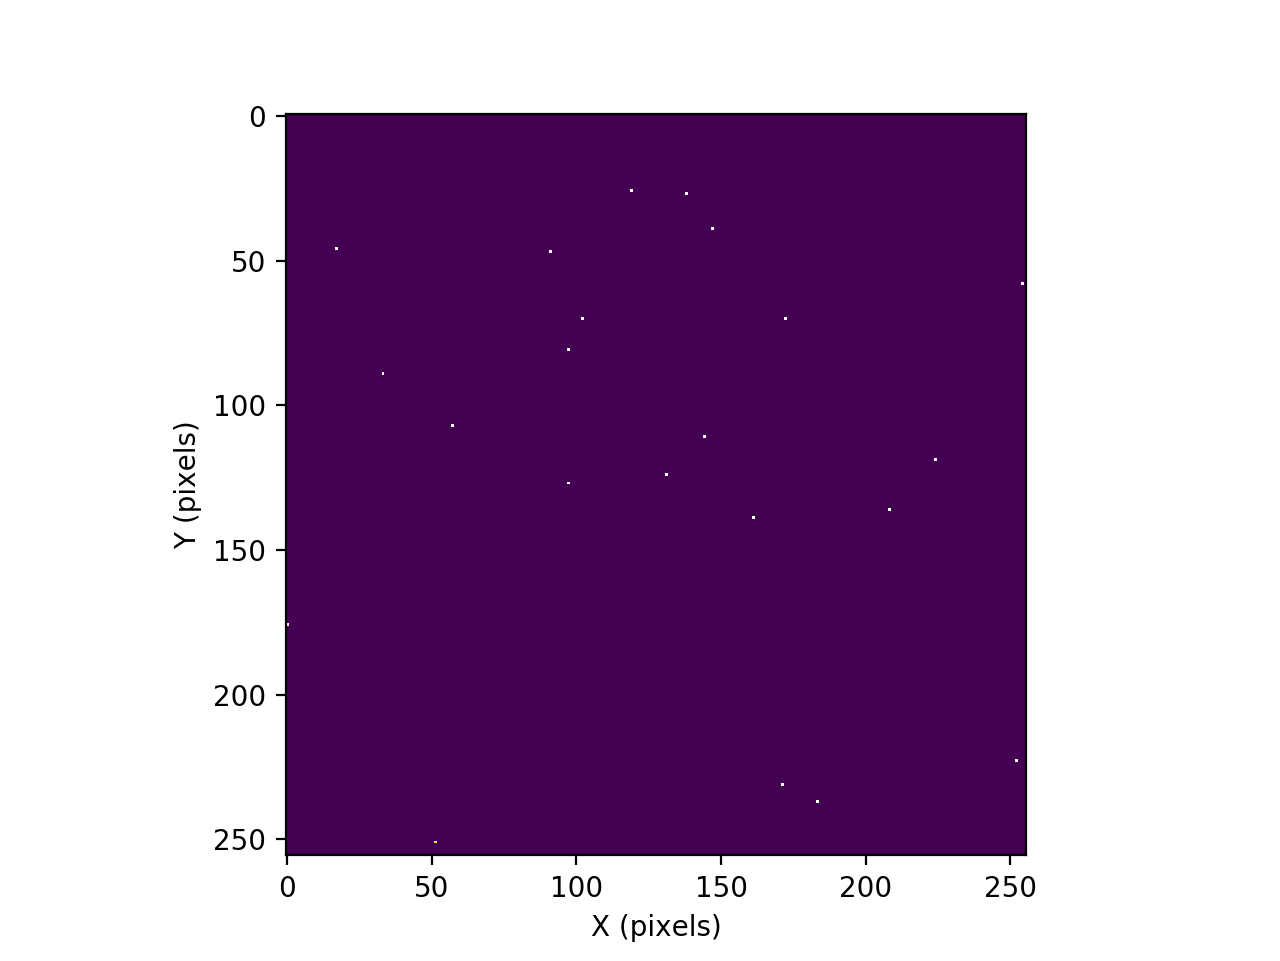

In [14]:
%matplotlib notebook
timeslice = 2
plt.imshow(hdulist[0].data[timeslice])
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.savefig('mirisiminput.png',dpi=100)

### Feeding the data cube to MEDIS

Start by setting the MEDIS simulation parameters

In [7]:

#simulation params
#use defaults

#Astro params
ap

#Telescope params
# SCExAO
tp.entrance_d = 0.051  # diameter of optics in SCExAO train are 2 inches=0.051 m

tp.d_tweeter = 0.051  # diameter of optics in SCExAO train are 2 inches=0.051 m
tp.act_tweeter = 50  # approx a 2000 actuator DM, (45x45=2025)
tp.fl_SxOAPG = 0.255  # m focal length of Genera SCExAO lens (OAP1,3,4,5)
tp.fl_SxOAP2 = 0.519  # m focal length of SCExAO OAP 2
tp.d_SxOAPG = 0.051  # diameter of SCExAO OAP's

tp.dist_SxOAP1_scexao = 0.1345  # m
tp.dist_scexao_sl2 = 0.2511 - tp.dist_SxOAP1_scexao  # m
tp.dist_sl2_focus = 0.1261  # m

tp.lens_params = [{'aber_vals': [7.2e-17, 0.8, 3.1],
                   'diam': tp.d_SxOAPG,
                   'fl': tp.fl_SxOAPG,
                   'dist': tp.fl_SxOAPG,
                   'name': 'SxOAPG'},

                 {'aber_vals': [7.2e-17, 0.8, 3.1],
                   'diam': tp.d_SxOAPG,
                   'fl': tp.fl_SxOAP2,
                   'dist': tp.fl_SxOAP2,
                   'name': 'SxOAP2'}
                 ]
# ------------------------------
# Coronagraph
tp.cg_type = 'Gaussian'
# tp.cg_size = 3  # physical size or lambda/D size
tp.cg_size = 1.5  # physical size or lambda/D size
tp.cg_size_units = "l/D"  # "m" or "l/D"
tp.fl_cg_lens = tp.fl_SxOAPG  # m
tp.lyot_size = 0.95  # units are in fraction of surface un-blocked

<IPython.core.display.Javascript object>


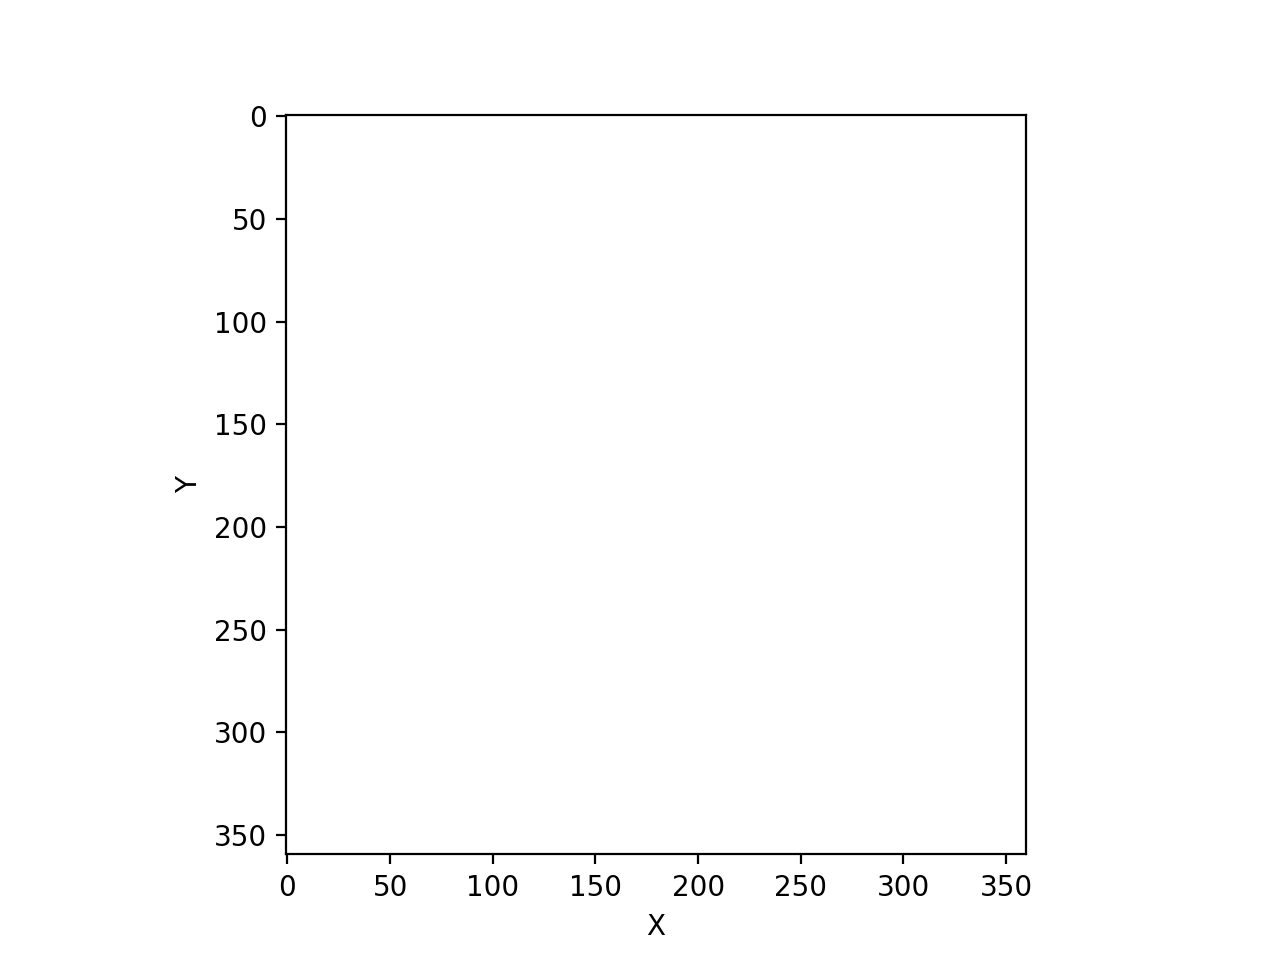

Text(0, 0.5, 'Y')

In [18]:
from scipy import fftpack
F1 = fftpack.fft2(hdulist[0].data[timeslice].astype(float))
F2 = fftpack.fftshift(F1)
psd2D = np.abs(F2)**2
plt.imshow(np.log10(psd2D))
plt.xlabel("X")
plt.ylabel("Y")

<IPython.core.display.Javascript object>


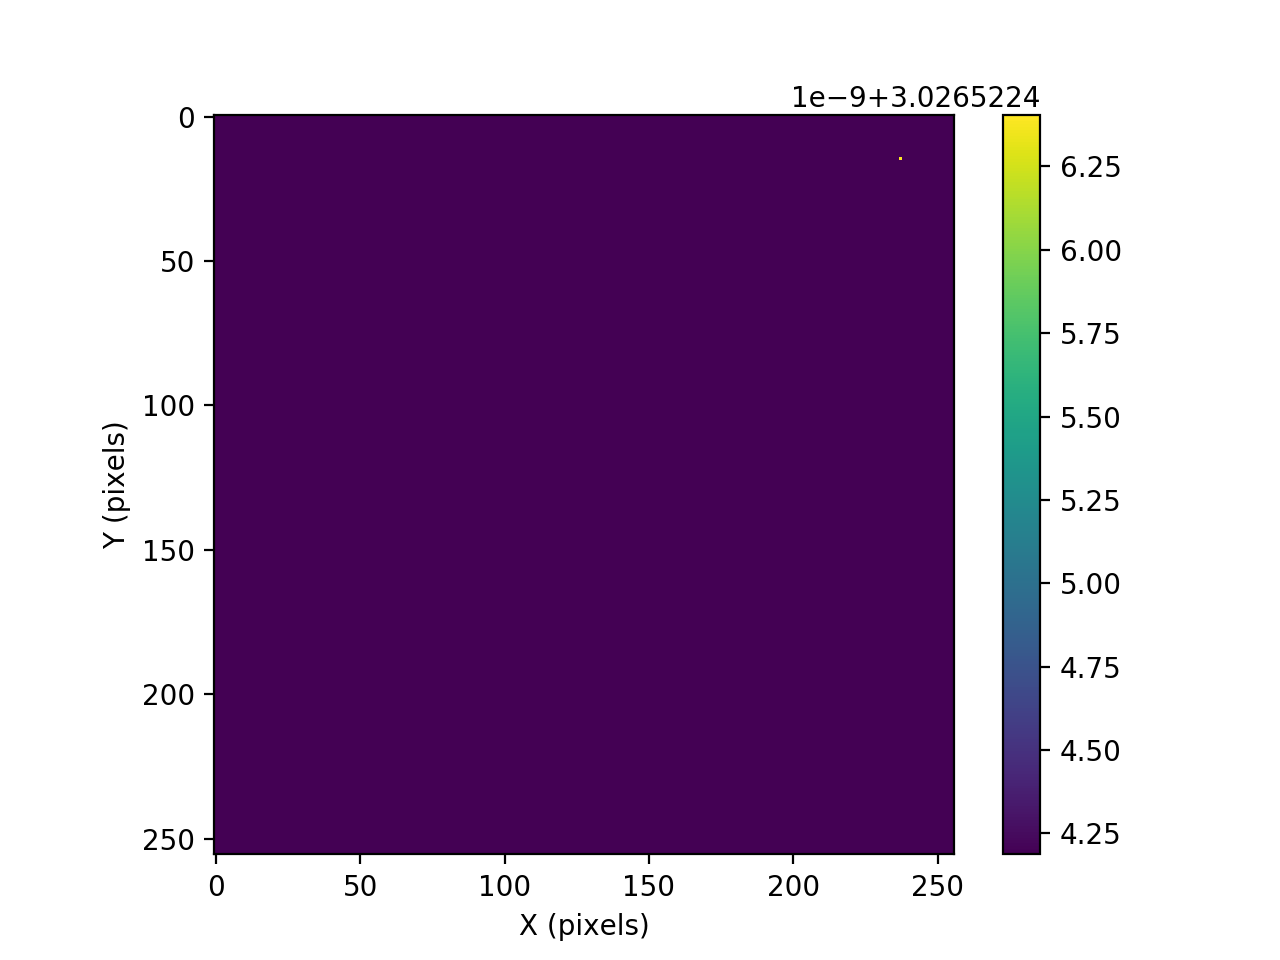

3.0265224064036564


In [15]:
%matplotlib notebook
hdulist = fits.open("/Users/shashank/AnacondaProjects/MKIDsim/shashank_example_scene.fits")
hdulist[0].data.shape
hdulist[0].header
timeslice = 0
hdulist[0].data = np.nan_to_num(hdulist[0].data)
plt.imshow(hdulist[0].data[timeslice])
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
print(np.max(hdulist[0].data[timeslice]))
plt.colorbar()

<IPython.core.display.Javascript object>


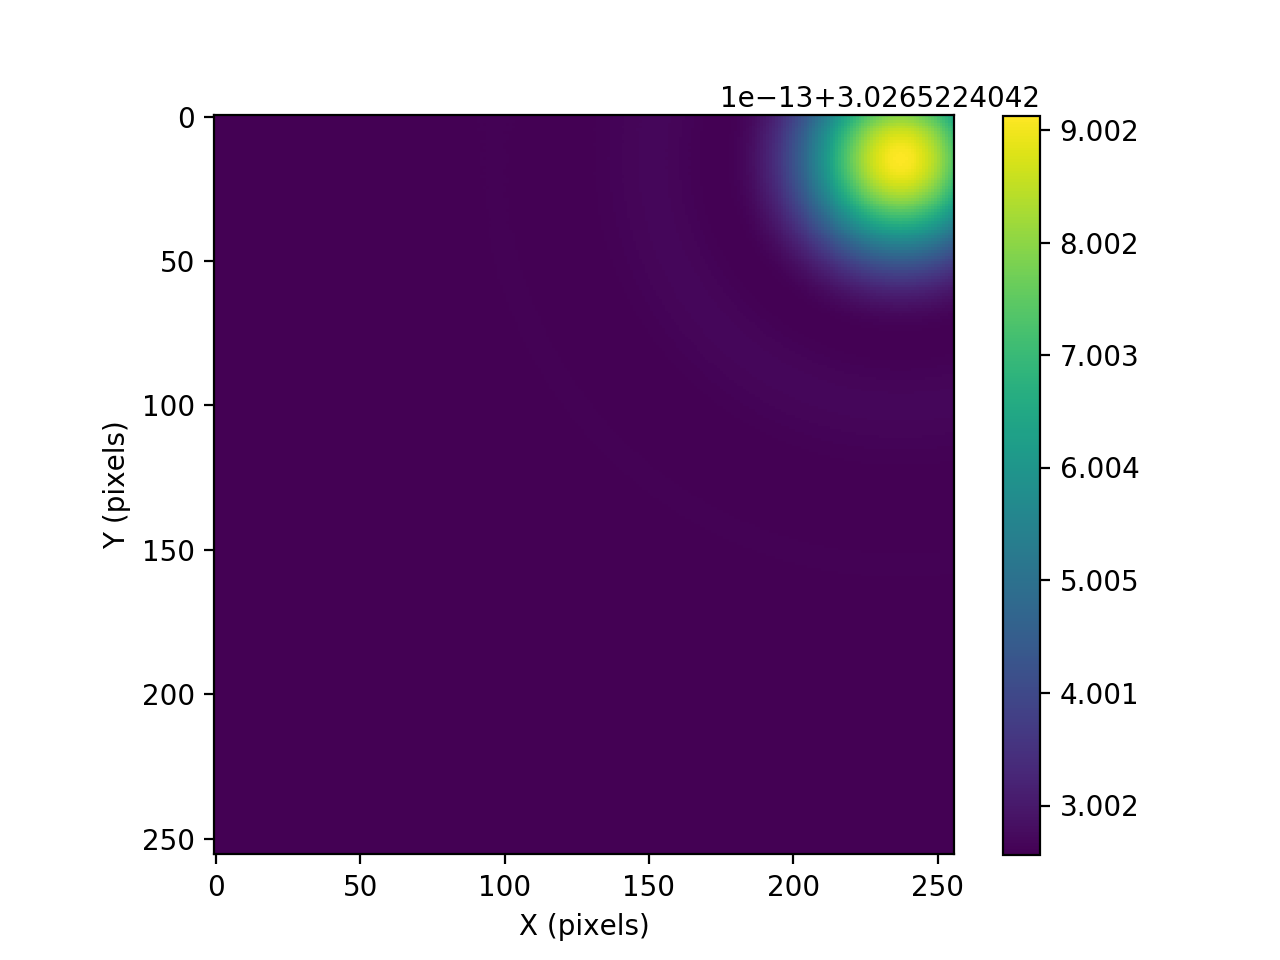

In [19]:
from astropy.convolution import AiryDisk2DKernel
airydisk_2D_kernel = AiryDisk2DKernel(64)
convolved = convolve(hdulist[0].data[timeslice],airydisk_2D_kernel,boundary='extend',normalize_kernel=True)
plt.imshow(convolved)
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar()